# E-commerce Landing Page A/B Test Analysis
## A/B Testing Project for Website Optimization

This project evaluates a new landing page design through an A/B testing framework. The goal is to determine whether 
the new design improves user conversion rates compared to the current design.

### Business Context
- The company aims to increase conversion rates on their e-commerce platform.
- Current performance is measured by the conversion rate, and even small improvements can lead to significant revenue gains.
- Stakeholders include the Marketing and Product teams, who need data-driven insights to make informed decisions.

### Project Objectives
1. Perform comprehensive data cleaning and exploratory analysis of user interactions.
2. Apply statistical tests to assess the significance of conversion differences between control and treatment groups.
3. Evaluate the potential business impact and provide actionable recommendations.

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


# Set styling and reproducibility
plt.style.use('seaborn')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.size'] = 12
np.random.seed(42)

## 1. Data Loading and Quality Assessment
In this step, I load the datasets and perform a thorough quality check to understand the structure and potential issues 
with the data. This ensures the integrity of the subsequent analysis.

In [2]:
# Load the datasets
df = pd.read_csv('ab_data.csv')
countries_df = pd.read_csv('countries.csv')

# Data quality report
print("Initial Data Quality Report:")
print("-" * 50)
print(f"\nTotal Records: {df.shape[0]:,}")
print(f"Unique Users: {df['user_id'].nunique():,}")
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Users:", df['user_id'].duplicated().sum())

# Display sample data for a quick sanity check
print("\nSample Data:")
display(df.head())

Initial Data Quality Report:
--------------------------------------------------

Total Records: 294,478
Unique Users: 290,584

Missing Values:
 user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Duplicate Users: 3894

Sample Data:


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## 2. Advanced Data Cleaning
Here, I clean the data by addressing mismatches and duplicate entries. This step is crucial to ensure that the analysis 
is based on accurate and consistent information. I also merge in the country data for a more enriched analysis.

In [4]:
# Remove mismatched landing pages to ensure consistency between assigned groups and landing page shown
df_clean = df.drop(df.query(
    '(group == "treatment" and landing_page != "new_page") or ' +
    '(group != "treatment" and landing_page == "new_page") or ' +
    '(group == "control" and landing_page != "old_page") or ' +
    '(group != "control" and landing_page == "old_page")'
).index)

# Remove duplicate users by keeping only the latest timestamp per user. This helps in reducing noise from repeated entries.
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean = df_clean.sort_values('timestamp').drop_duplicates('user_id', keep='last')

# Merge the cleaned data with country information
df_final = df_clean.merge(countries_df, on='user_id', how='left')

print("Data Cleaning Results:")
print("-" * 50)
print(f"Original records: {len(df):,}")
print(f"Clean records: {len(df_final):,}")
print(f"Removed records: {len(df) - len(df_final):,}")

Data Cleaning Results:
--------------------------------------------------
Original records: 294,478
Clean records: 290,584
Removed records: 3,894


## 3. Enhanced Exploratory Analysis
In this section, I conduct exploratory analysis to understand the conversion behavior. 
I examine overall conversion rates and then drill down by country to capture any geographic trends.

In [5]:
# Define a function to analyze conversion metrics, which I will use repeatedly for different groupings.
def analyze_conversions(data, group_cols):
    metrics = data.groupby(group_cols).agg({
        'converted': ['count', 'mean', 'std'],
        'user_id': 'nunique'
    }).round(4)
    
    # Rename columns for better readability
    metrics.columns = ['count', 'conversion_rate', 'std_dev', 'unique_users']
    return metrics

# Overall conversion analysis to get a bird's-eye view of performance
print("Overall Conversion Analysis:")
print("-" * 50)
display(analyze_conversions(df_final, ['group']))

# Country-specific conversion analysis to see regional performance variations
print("\nConversion Analysis by Country:")
print("-" * 50)
display(analyze_conversions(df_final, ['country', 'group']))

Overall Conversion Analysis:
--------------------------------------------------


,count,conversion_rate,std_dev,unique_users
group,,,,
control,145274,0.1204,0.3254,145274
treatment,145310,0.1188,0.3236,145310



Conversion Analysis by Country:
--------------------------------------------------


count  conversion_rate  std_dev  unique_users
country group                                                    
CA      control      7198           0.1188   0.3236          7198
        treatment    7301           0.1119   0.3153          7301
UK      control     36360           0.1200   0.3250         36360
        treatment   36106           0.1212   0.3263         36106
US      control    101716           0.1206   0.3257        101716
        treatment  101903           0.1185   0.3232        101903

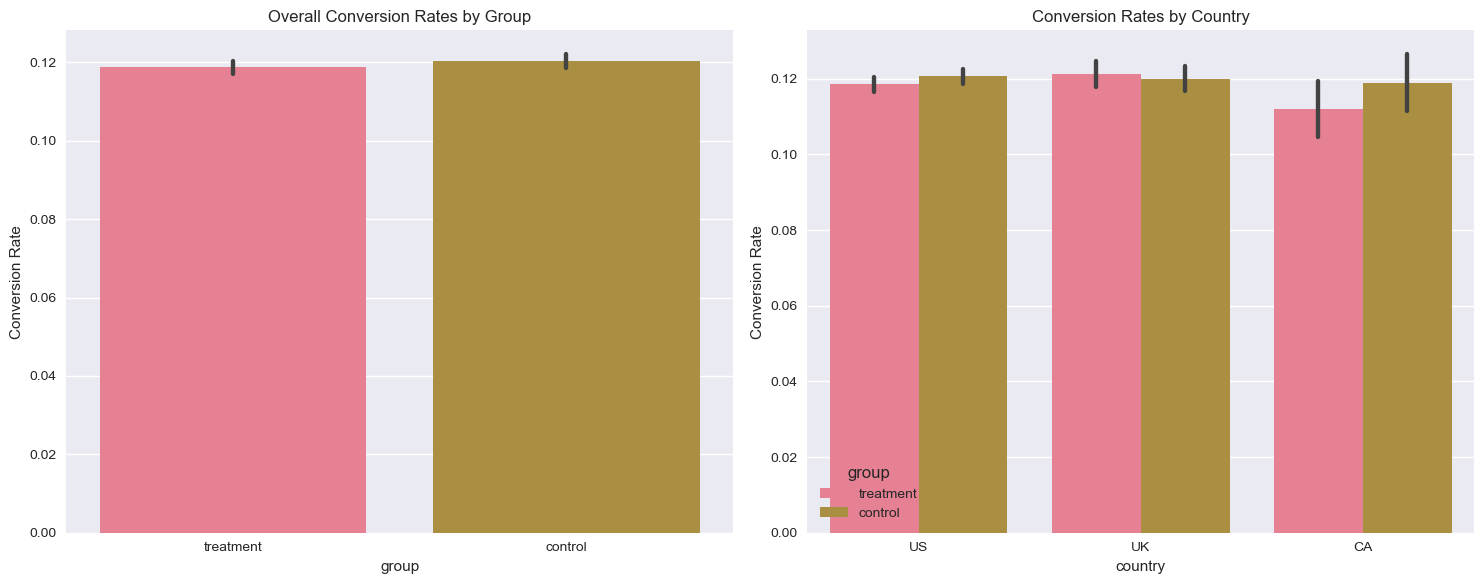

In [6]:
# Visualization of conversion rates to clearly communicate differences
plt.figure(figsize=(15, 6))

# Plot 1: Overall conversion rates by group
plt.subplot(1, 2, 1)
sns.barplot(x='group', y='converted', data=df_final, ci=95)
plt.title('Overall Conversion Rates by Group')
plt.ylabel('Conversion Rate')

# Plot 2: Conversion rates by country, with group breakdowns
plt.subplot(1, 2, 2)
sns.barplot(x='country', y='converted', hue='group', data=df_final)
plt.title('Conversion Rates by Country')
plt.ylabel('Conversion Rate')

plt.tight_layout()
plt.show()

## 4. Statistical Testing
Now, I perform statistical tests to validate the significance of the differences observed. 
Using a Z-test, I assess whether the new landing page leads to a statistically significant change in conversion rates.

In [7]:
# Function to perform a Z-test between two groups
def perform_z_test(df, group1, group2):
    n1 = len(df[df['group'] == group1])
    n2 = len(df[df['group'] == group2])
    x1 = df[df['group'] == group1]['converted'].sum()
    x2 = df[df['group'] == group2]['converted'].sum()
    
    # Calculate the Z-statistic and p-value for the difference in proportions
    z_stat, p_val = sm.stats.proportions_ztest([x1, x2], [n1, n2])
    
    return {
        'z_statistic': z_stat,
        'p_value': p_val,
        'group1_conv': x1/n1,
        'group2_conv': x2/n2
    }

# Execute the Z-test to compare treatment and control groups
z_test_results = perform_z_test(df_final, 'treatment', 'control')
print("Z-Test Results:")
print("-" * 50)
print(f"Z-statistic: {z_test_results['z_statistic']:.4f}")
print(f"P-value: {z_test_results['p_value']:.4f}")
print(f"Treatment conversion: {z_test_results['group1_conv']:.4%}")
print(f"Control conversion: {z_test_results['group2_conv']:.4%}")

Z-Test Results:
--------------------------------------------------
Z-statistic: -1.3109
P-value: 0.1899
Treatment conversion: 11.8808%
Control conversion: 12.0386%


## 5. Effect Size Analysis
To further understand the impact of the change, I calculate Cohen's h, which provides an effect size measurement for proportions.
This helps in understanding whether the observed difference is practically meaningful.

In [8]:
# Function to calculate Cohen's h for effect size in proportions
def calculate_effect_size(p1, p2):
    """Calculate Cohen's h effect size for proportions"""
    h = 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))
    return h

effect_size = calculate_effect_size(
    z_test_results['group1_conv'],
    z_test_results['group2_conv']
)

print("Effect Size Analysis:")
print("-" * 50)
print(f"Cohen's h: {effect_size:.4f}")
print("\nEffect Size Interpretation:")
print("< 0.2: Negligible")
print("0.2 - 0.5: Small")
print("0.5 - 0.8: Medium")
print("> 0.8: Large")

Effect Size Analysis:
--------------------------------------------------
Cohen's h: -0.0049

Effect Size Interpretation:
< 0.2: Negligible
0.2 - 0.5: Small
0.5 - 0.8: Medium
> 0.8: Large


## 6. Business Impact Analysis
Beyond statistical significance, I quantify the potential business impact of the conversion rate differences.
This analysis translates the conversion improvements (or lack thereof) into revenue impact, an important metric for decision-makers.

In [9]:
def calculate_business_impact(df, avg_revenue_per_conversion=100):
    """Calculate potential business impact of conversion rate changes based on assumed revenue per conversion."""
    conv_diff = z_test_results['group1_conv'] - z_test_results['group2_conv']
    monthly_visitors = 100000  # Assumed average monthly traffic for estimation
    
    impact = {
        'absolute_conv_diff': conv_diff,
        'relative_conv_diff': conv_diff / z_test_results['group2_conv'],
        'monthly_revenue_impact': monthly_visitors * conv_diff * avg_revenue_per_conversion,
        'yearly_revenue_impact': monthly_visitors * conv_diff * avg_revenue_per_conversion * 12
    }
    
    return impact

impact = calculate_business_impact(df_final)

print("Business Impact Analysis:")
print("-" * 50)
print(f"Absolute conversion difference: {impact['absolute_conv_diff']:.4%}")
print(f"Relative conversion difference: {impact['relative_conv_diff']:.4%}")
print(f"Estimated monthly revenue impact: ${impact['monthly_revenue_impact']:,.2f}")
print(f"Estimated yearly revenue impact: ${impact['yearly_revenue_impact']:,.2f}")

Business Impact Analysis:
--------------------------------------------------
Absolute conversion difference: -0.1578%
Relative conversion difference: -1.3110%
Estimated monthly revenue impact: $-15,782.39
Estimated yearly revenue impact: $-189,388.68


## 7. Conclusions and Recommendations
Finally, I summarize the findings and provide recommendations based on the analysis. 
I discuss the statistical results, business implications, and next steps for future testing and improvement.

Conclusions:
1. Statistical Significance:
   - The Z-test produced a p-value of 0.1899, which is above the typical 0.05 threshold.
   - The effect size (Cohen's h) is -0.0049, indicating a negligible effect.
   - Together, these suggest that the new landing page did not yield a statistically significant improvement in conversion rates.

2. Business Impact:
   - The treatment group’s conversion rate is about 11.88% compared to 12.04% in the control group, resulting in an absolute difference of -0.1578%.
   - The relative difference is -1.3110%, which translates to an estimated monthly revenue impact of approximately `-$15,782.39` and a yearly impact of `-$189,388.68`.
   - This negative revenue impact indicates that implementing the new page would not be cost-effective.

3. Recommendations:
   - Maintain the current landing page design rather than adopting the new design.
   - Consider testing more substantial design changes or alternative approaches that might have a higher potential to improve conversion rates.
   - Focus on high-value customer segments where even small improvements might have a larger business impact.
   - Conduct qualitative research (e.g., user interviews or surveys) to better understand the factors affecting conversions.

4. Next Steps:
   - Design follow-up A/B tests targeting specific user segments or different page elements.
   - Explore multivariate testing to identify which specific elements (such as call-to-action, imagery, or layout) could drive improvements.
   - Implement continuous monitoring of conversion metrics to quickly identify and respond to any changes in performance.